# Recommendation System
Now that the data has been cleaned, the recommender system can be engaged. This will be a **contenet-based recommender system**  where recommendations are based on the similarity of the vehicle features and not on explicit (user preference or profile) user metadata.

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
import re
import string
import random
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("vehicles_rec.csv")

In [3]:
# Function for recommending cars based on car manufacturer country. 
# It takes car manufacturer country, color group, type group  and price range as input.

def recommend(made, color_group, type_group, price_range):

    # Matching the type with the dataset and reset the index
    data = df.loc[(df['color_group'] == color_group) & (df['type_group'] == type_group) & ((df['price']>=price_range[0]) & 
                    (df['price']<=price_range[1]))]
    data.reset_index(level=0,inplace=True)
  
    # Convert the index into series
    indices = pd.Series(data.index, index = data['Made'])
    
    #Converting the car manufacturer country into vectors and used unigram
    tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 1), min_df = 1, stop_words='english')
    tfidf_matrix = tf.fit_transform(data['Made'])
    
    # Calculating the similarity measures based on Cosine Similarity
    sg = cosine_similarity(tfidf_matrix)
    # Get the index corresponding to original_manufacturer
    idx = indices[made]
    # Get the pairwsie similarity scores 
    sig = list(enumerate(sg[idx]))
    # Sort the cars
    sig = sorted(sig, reverse=True)
    # Scores of the 6 most similar cars 
    sig = sig[0:6]
    # car indicies
    car_indices = [i[0] for i in sig]
    # Top 6 car recommendations
    rec = data[['price','Made','manufacturer', 'model','type','year','Age','condition','fuel','title_status'
                ,'transmission','paint_color','mil_rating','state']].iloc[car_indices]
    return rec

In [4]:
recommend("American","light color","luxury_small",(5000,10000))

,price,Made,manufacturer,model,type,year,Age,condition,fuel,title_status,transmission,paint_color,mil_rating,state
2289,9500,American,ford,econoline e350,other,2007,15,good,gas,clean,automatic,white,below average,fl
2288,8900,German,volkswagen,passat,sedan,2012,10,excellent,gas,clean,automatic,silver,below average,fl
2287,5700,American,mercury,cougar,coupe,1996,26,excellent,gas,clean,automatic,green,below average,fl
2286,7300,English,mini,cooper,hatchback,2013,9,good,gas,clean,manual,white,below average,fl
2285,7200,German,audi,a4,sedan,2010,12,good,gas,clean,automatic,silver,below average,fl
2284,5998,Japanese,toyota,prius,hatchback,2012,10,excellent,hybrid,clean,automatic,silver,below average,fl


In [78]:
print(tf.vocabulary_)

{'american': 0, 'japanese': 4, 'german': 2, 'korean': 5, 'english': 1, 'italian': 3, 'swedish': 6}


In [77]:
all_feature_names = tf.get_feature_names_out()

for word in all_feature_names:
    indx = tf.vocabulary_.get(word)
    print(f"{word} {tf.idf_[indx]}")

american 2.0381877050414507
english 4.79132476578661
german 3.014516696411518
italian 5.968268897724626
japanese 1.9279504053561582
korean 3.503942955636647
swedish 5.990741753576685


# Data Modeling (Price Prediction)

In [7]:
df.drop(['posting_date','mil_rating','Made','type_group'
         ,'color_group','postmd','avg_mil','region'],axis=1,inplace=True)

E:\Anaconda3\envs\dev\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


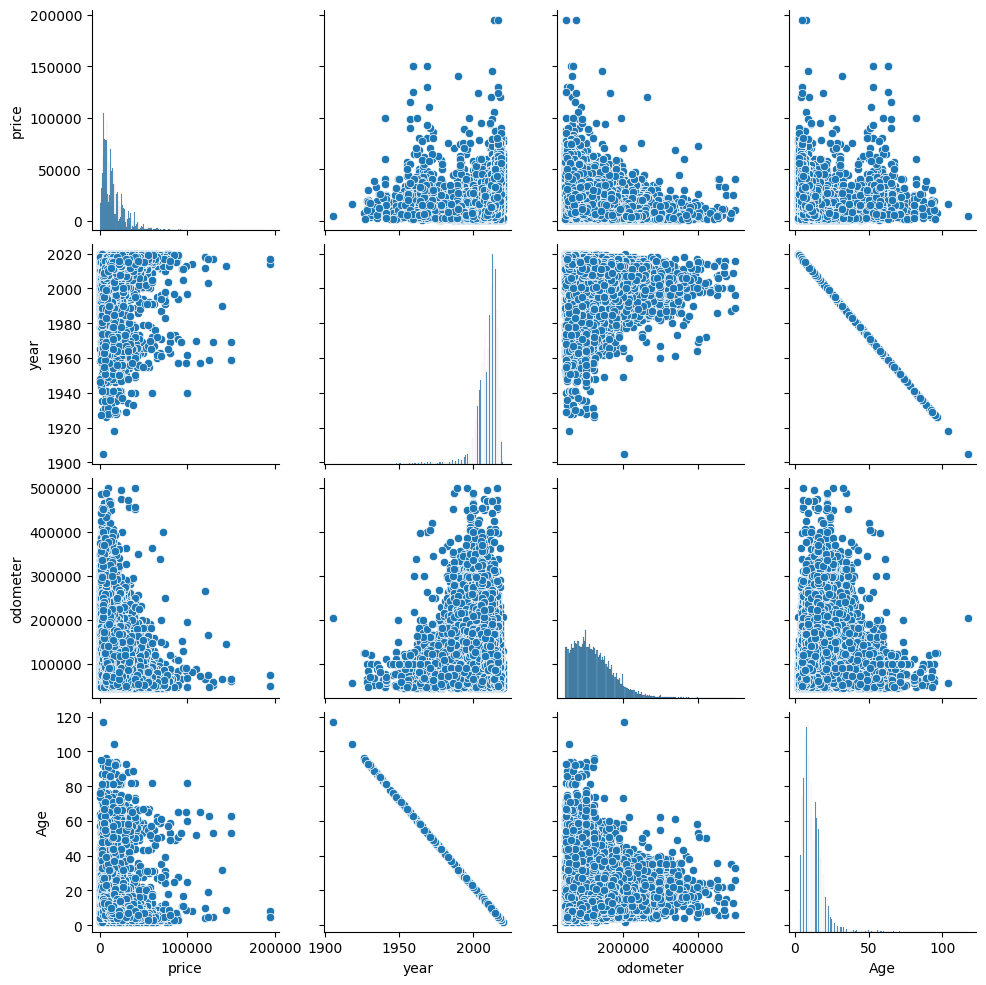

In [8]:
import seaborn as sns
sns.pairplot(df)

In [9]:
df.cylinders.value_counts()

cylinders
6 cylinders     38326
4 cylinders     34377
8 cylinders     29182
5 cylinders       921
10 cylinders      510
other             359
3 cylinders       129
12 cylinders       38
Name: count, dtype: int64

In [10]:
df.cylinders.replace("other",np.nan,inplace=True)
df.cylinders.value_counts()

cylinders
6 cylinders     38326
4 cylinders     34377
8 cylinders     29182
5 cylinders       921
10 cylinders      510
3 cylinders       129
12 cylinders       38
Name: count, dtype: int64

In [11]:
#normalize the cylinders value counts and save into a dataframe
cyl_prob = pd.DataFrame(list(df.cylinders.value_counts(normalize=True).items()),columns = ['cylinders','prob'])
#substitute missing values in cylinder to random states based on their probabilities
df.loc[df.cylinders.isna(), 'cylinders'] = np.random.choice(cyl_prob.cylinders, 
                                                size=df.cylinders.isna().sum(),
                                                replace=True, 
                                                p=cyl_prob.prob)

In [12]:
#since cylinder has the word 'cylinder' after the number, we remove it and make it numerical
df['cylinders']=df['cylinders'].apply(lambda x:x.split(' ')[0])
df['cylinders']=df['cylinders'].astype('int')
df['cylinders'].dtype

dtype('int32')

<Axes: >

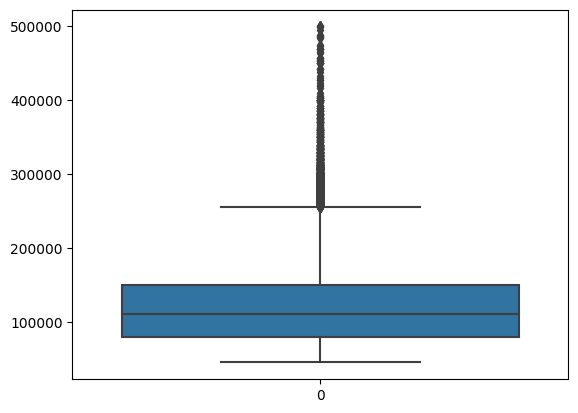

In [13]:
cols=['odometer','cylinders']
sns.boxplot(df[cols[0]])

<Axes: >

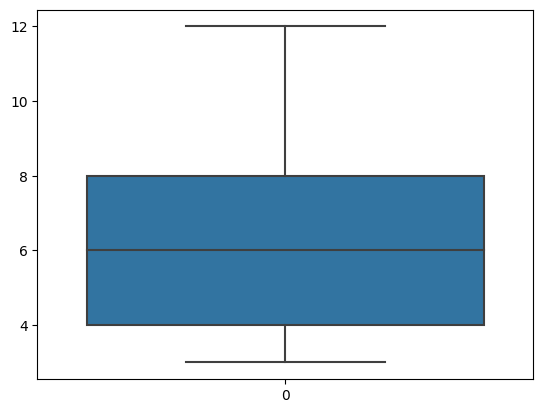

In [14]:
sns.boxplot(df[cols[1]])

odometer
--------------------------------------------------
Percentiles: 25th=79393.000, 75th=150000.000, IQR=70607.000
Lower: -26517.5  Upper: 255910.5
Identified outliers: 1652
Non-outlier observations: 102190


<Axes: >

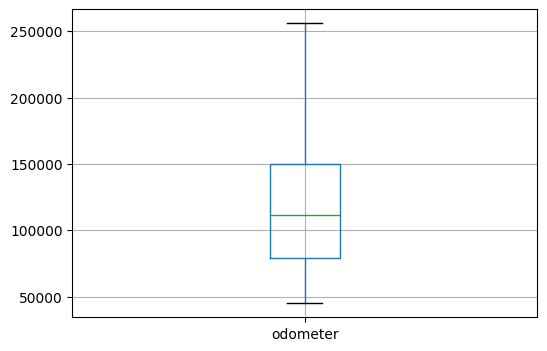

In [15]:
#further remove outliers in odometer for model purposes
def find_outliers_limit(df,col):
    print(col)
    print('-'*50)
    #removing outliers
    q25, q75 = np.percentile(df[col], 25), np.percentile(df[col], 75)
    iqr = q75 - q25
    print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))
    # calculate the outlier cutoff
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off
    print('Lower:',lower,' Upper:',upper)
    return lower,upper
def remove_outlier(df,col,upper,lower):
    # identify outliers
    outliers = [x for x in df[col] if x > upper or x < lower]
    print('Identified outliers: %d' % len(outliers))
    # remove outliers
    outliers_removed = [x for x in df[col] if x >= lower and x <= upper]
    print('Non-outlier observations: %d' % len(outliers_removed))
    final= np.where(df[col]>upper,upper,np.where(df[col]<lower,lower,df[col]))
    return final
outlier_cols=['odometer']
for col in outlier_cols:
    lower,upper=find_outliers_limit(df,col)
    df[col]=remove_outlier(df,col,upper,lower)
    
plt.figure(figsize=(6,4))
df[outlier_cols].boxplot()

# Handling Categorical Data

In [18]:
# Loading Libraries
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error,mean_squared_error,mean_absolute_error,mean_absolute_percentage_error,r2_score
import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from prettytable import PrettyTable

In [19]:
#select numerical and categorical data
num_df=df.select_dtypes(include=np.number)
cat_df=df.select_dtypes(include=object)
#assign encoder
encoding=OrdinalEncoder()
#place categorical columns to list and encode
cat_cols=cat_df.columns.tolist()
encoding.fit(cat_df[cat_cols])
#transform categorical encoding and place in dataframe
cat_oe=encoding.transform(cat_df[cat_cols])
cat_oe=pd.DataFrame(cat_oe,columns=cat_cols)
cat_df.reset_index(inplace=True,drop=True)

In [20]:
cat_oe.head()

,url,manufacturer,model,condition,fuel,title_status,transmission,drive,type,paint_color,state
0,6601.0,14.0,3316.0,0.0,2.0,0.0,0.0,2.0,8.0,0.0,0.0
1,6921.0,6.0,8732.0,0.0,0.0,0.0,0.0,0.0,10.0,5.0,0.0
2,6540.0,27.0,5715.0,2.0,4.0,0.0,2.0,1.0,4.0,8.0,0.0
3,6606.0,30.0,5387.0,0.0,2.0,0.0,0.0,1.0,9.0,9.0,0.0
4,7199.0,6.0,2552.0,1.0,2.0,0.0,0.0,2.0,9.0,10.0,0.0


In [23]:
num_df.reset_index(inplace=True,drop=True)

cat_oe.reset_index(inplace=True,drop=True)

final_all_df=pd.concat([num_df,cat_oe],axis=1)

In [26]:
final_all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103842 entries, 0 to 103841
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         103842 non-null  int64  
 1   year          103842 non-null  int64  
 2   cylinders     103842 non-null  int32  
 3   odometer      103842 non-null  float64
 4   Age           103842 non-null  int64  
 5   url           103842 non-null  float64
 6   manufacturer  103842 non-null  float64
 7   model         103842 non-null  float64
 8   condition     103842 non-null  float64
 9   fuel          103842 non-null  float64
 10  title_status  103842 non-null  float64
 11  transmission  103842 non-null  float64
 12  drive         103842 non-null  float64
 13  type          103842 non-null  float64
 14  paint_color   103842 non-null  float64
 15  state         103842 non-null  float64
dtypes: float64(12), int32(1), int64(3)
memory usage: 12.3 MB


<Axes: >

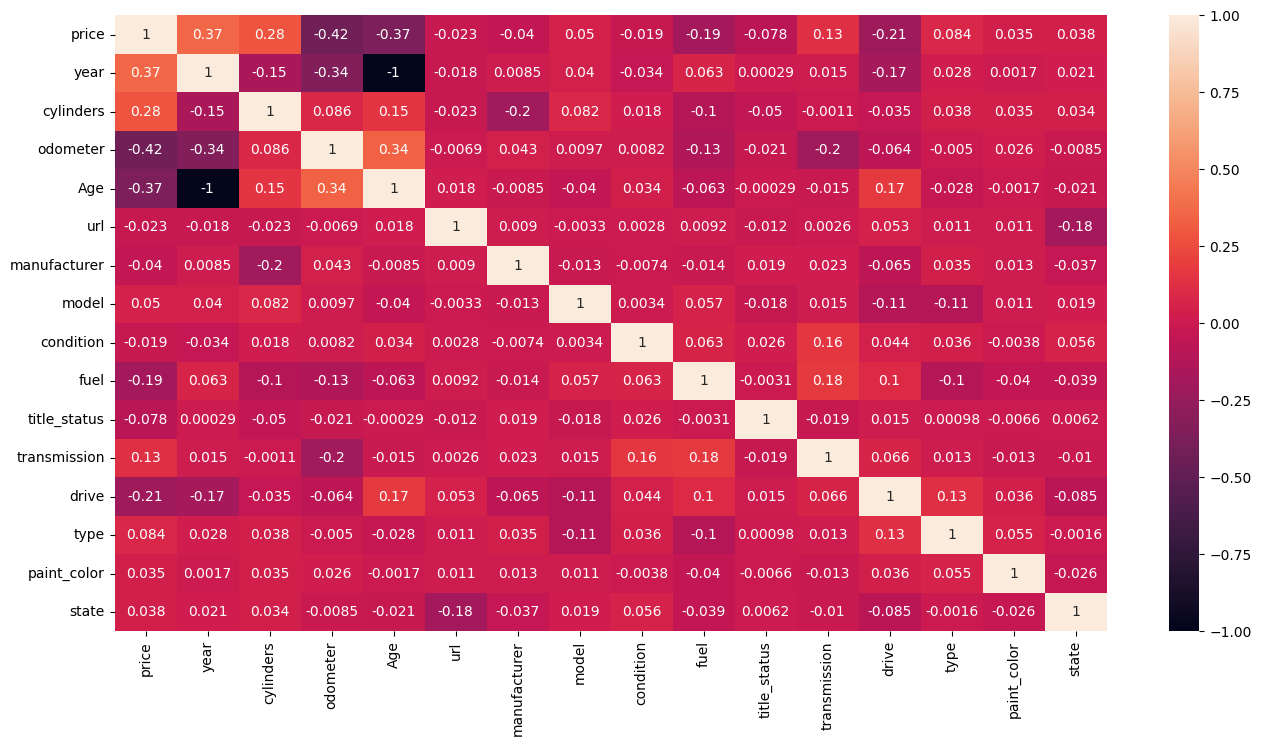

In [28]:
#plot the correlation matrix
plt.figure(figsize=(16,8))
sns.heatmap(data=final_all_df.corr(),annot=True)

There are only a few categories having a medium level correlation with price, namely: **year, odometer, cylinders and age** (similar to year). Transforming the price lead to a slight increase in the correlation of some of those categories. As such, the log transformation of price will be used to tain the model.

In [30]:
data_reg = df.loc[:, ['price', 'year', 'Age', 'odometer','cylinders','manufacturer', 'model', 'fuel', 
                      'title_status', 'transmission', 'condition',  'drive',
                      'type', 'paint_color', 'state']]
label_reg = data_reg
data_reg_original = data_reg
data_reg.head()

,price,year,Age,odometer,cylinders,manufacturer,model,fuel,title_status,transmission,condition,drive,type,paint_color,state
0,11975,2003,19,207000.0,8,harley-davidson,davidson,gas,clean,automatic,excellent,rwd,pickup,black,ca
1,21950,2003,19,202537.0,8,chevrolet,silverado 3500,diesel,clean,automatic,excellent,4wd,truck,grey,ca
2,15590,2015,7,60291.0,8,mini,hardtop 2 door cooper s,other,clean,other,good,fwd,hatchback,red,ca
3,3975,2006,16,187000.0,4,pontiac,g6,gas,clean,automatic,excellent,fwd,sedan,silver,ca
4,8000,1972,50,61000.0,8,chevrolet,chevelle,gas,clean,automatic,fair,rwd,sedan,white,ca


##### Label Encoding
We will be using LabelEncoder to convert categorical values to assign numerical values or the model

In [31]:
label_reg = data_reg

le_manufacturer = LabelEncoder()
le_model = LabelEncoder()
le_fuel = LabelEncoder()
le_title_status = LabelEncoder()
le_transmission = LabelEncoder()
le_condition = LabelEncoder()
le_drive = LabelEncoder()
le_type = LabelEncoder()
le_color = LabelEncoder()
le_state = LabelEncoder()

label_reg["type"] = le_type.fit_transform(label_reg['type'])
label_reg["manufacturer"] = le_manufacturer.fit_transform(label_reg['manufacturer'])
label_reg['paint_color'] = le_color.fit_transform(label_reg['paint_color'])
label_reg['drive'] = le_drive.fit_transform(label_reg['drive'])
label_reg["fuel"] = le_fuel.fit_transform(label_reg['fuel'])
label_reg["title_status"] = le_title_status.fit_transform(label_reg['title_status'])
label_reg['transmission'] = le_transmission.fit_transform(label_reg['transmission'])
label_reg['condition'] = le_condition.fit_transform(label_reg['condition'])
label_reg['state'] = le_state.fit_transform(label_reg['state'])
label_reg['model'] = le_model.fit_transform(label_reg['model'])

label_reg.head()

,price,year,Age,odometer,cylinders,manufacturer,model,fuel,title_status,transmission,condition,drive,type,paint_color,state
0,11975,2003,19,207000.0,8,14,3316,2,0,0,0,2,8,0,0
1,21950,2003,19,202537.0,8,6,8732,0,0,0,0,0,10,5,0
2,15590,2015,7,60291.0,8,27,5715,4,0,2,2,1,4,8,0
3,3975,2006,16,187000.0,4,30,5387,2,0,0,0,1,9,9,0
4,8000,1972,50,61000.0,8,6,2552,2,0,0,1,2,9,10,0


To build the prediction model, split the data into train and test data in an 80-20 split.

In [32]:
X_regla = label_reg.drop('price', axis = 1)
y_regla = label_reg['price']

X_train, X_test, y_train, y_test = train_test_split(X_regla, y_regla, test_size = 0.2, random_state = 25)

We build three machine learning models and evaluate their performance to pick the best performing model for our price prediction.
 - Linear Regression model
 - XGBoost Regressor model
 - Random Forest Regressor model

In [33]:
# Model Building
def train_ml_model(x,y,model_type):
    if model_type=='lr':
        model=LinearRegression()
    elif model_type=='xgb':
        model=XGBRegressor()
    elif model_type=='rf':
        model=RandomForestRegressor()
    model.fit(x,y)
    
    return model

model_lr=train_ml_model(X_train,y_train,'lr')

model_xgb=train_ml_model(X_train,y_train,'xgb')

model_rf=train_ml_model(X_train,y_train,'rf')

In [34]:
#evaluate models
def model_evaluate(model,x,y):
    predictions=model.predict(x)
   # predictions=np.exp(predictions)
    mse=mean_squared_error(y,predictions)
    mae=mean_absolute_error(y,predictions)
    mape=mean_absolute_percentage_error(y,predictions)
    #msle=mean_squared_log_error(y,predictions)
    
    mse=round(mse,2)
    mae=round(mae,2)
    mape=round(mape,2)
    #msle=round(msle,2)
    
    return [mse,mae,mape]

summary=PrettyTable(['Model','MSE','MAE','MAPE'])
summary.add_row(['LR']+model_evaluate(model_lr,X_test,y_test))
summary.add_row(['XGB']+model_evaluate(model_xgb,X_test,y_test))
summary.add_row(['RF']+model_evaluate(model_rf,X_test,y_test))

print(summary)

+-------+-------------+---------+------+
| Model |     MSE     |   MAE   | MAPE |
+-------+-------------+---------+------+
|   LR  | 74031046.61 | 6176.55 | 0.69 |
|  XGB  | 17219810.11 | 2594.98 | 0.28 |
|   RF  | 16528937.99 |  2202.4 | 0.26 |
+-------+-------------+---------+------+


Above is the summary of the evaluation metrics used to evaluate the performance of the machine learing models. The parameters include mean square error (MSE), mean absolute error (MAE), and mean absolute percentage error (MAPE). The lower these evaluation metrics are, the better the model.

The most performing machine learning model appears to be the **Random Forest Regressor** model which has the lowest evaluation parameters 

In [35]:
rf = X_train.join(y_train)
price_pred_df=rf.join(pd.Series(model_rf.predict(X_train), name='price_pred'))
price_pred_df.to_csv('vehicles_price_pred.csv')

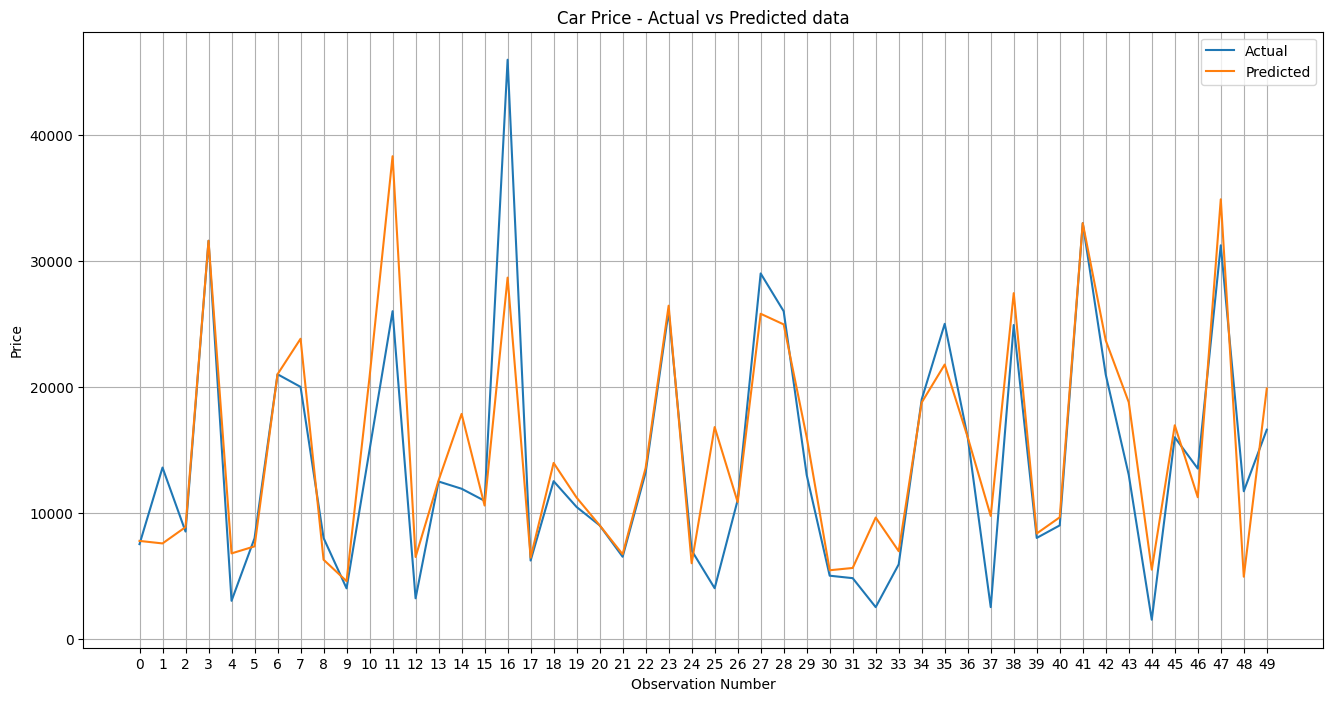

In [36]:
#plot the actual vs the predicted price
y_pred=(model_rf.predict(X_test))

number_of_observations=50

x_ax = range(len(y_test[:number_of_observations]))

plt.figure(figsize=(16,8))
plt.plot(x_ax, y_test[:number_of_observations], label="Actual")
plt.plot(x_ax, y_pred[:number_of_observations], label="Predicted")
plt.title("Car Price - Actual vs Predicted data")
plt.xlabel('Observation Number')
plt.ylabel('Price')
plt.xticks(np.arange(number_of_observations))
plt.legend()
plt.grid()
plt.show()

In [37]:
import pickle
rf_uc_model = 'rf_uc_model.sav'
pickle.dump(model_rf,open(rf_uc_model, 'wb'))

In [38]:
#load model for use using
loaded_model = pickle.load(open(rf_uc_model,'rb'))
result=loaded_model.score(X_test,y_test)
print(result)

0.8783209885388723


In [41]:
def predict(year,age,odom,cylin,manuf,model,fueltyp,title,transm,cond,drivetype,type,color,state):
    pred = (year,age,odom,cylin,manuf,model,fueltyp,title,transm,cond,drivetype,type,color,state)
    x = np.array([pred])
    #convert input using LabelEncoder
    le_reg = [np.nan,np.nan,np.nan,np.nan,le_manufacturer, le_model,le_fuel,le_title_status,le_transmission,
                  le_condition,le_drive,le_type,le_color,le_state]
    
    for i in range(4,14):
        x[:,i] = le_reg[i].transform(x[:,i])
        x
       
    loaded_model = pickle.load(open(rf_uc_model,'rb'))
    price_est = loaded_model.predict(x)
    return "Price Estimate =  $" + str(price_est)

In [42]:
predict(2013,8,100000.0,4,'nissan','maxima','gas','clean','automatic','good','rwd','sedan','blue','ca')

E:\Anaconda3\envs\dev\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


'Price Estimate =  $[11208.8]'

The loaded model has an estimate of the accuracy of **87.79%** on unseen data.

This seems to be a good model to use to predict used car prices.